In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import openai
import cv2,os
import sys
import argparse
sys.path.append('../../')
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
from models.utils.gpt_helper import (GPT4VisionClass,printmd, response_to_json, parse_and_get_action,
                                     extract_arguments, match_objects, decode_image)
print ("openai version:[%s]"%(openai.__version__))

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')


openai version:[1.3.8]


In [4]:
# 1. Start with Image description
model = GPT4VisionClass(key_path='../../key/rilab_key.txt', max_tokens=1024, temperature=0.9,
    gpt_model="gpt-4-vision-preview",
    role_msg="You are a helpful agent with vision capabilities; do not respond to objects not depicted in images."
    )

# 2. System prompt: functions, object_names
print("\033[94m [System prompt: infrom the format of the answer] \033[0m")


key_path:[../../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

 [System prompt: infrom the format of the answer] 


['7', '14', '24'] 3
['rgb_img_0.png', 'rgb_img_1.png', 'rgb_img_2.png', 'rgb_img_3.png', 'rgb_img_4.png', 'rgb_img_5.png']


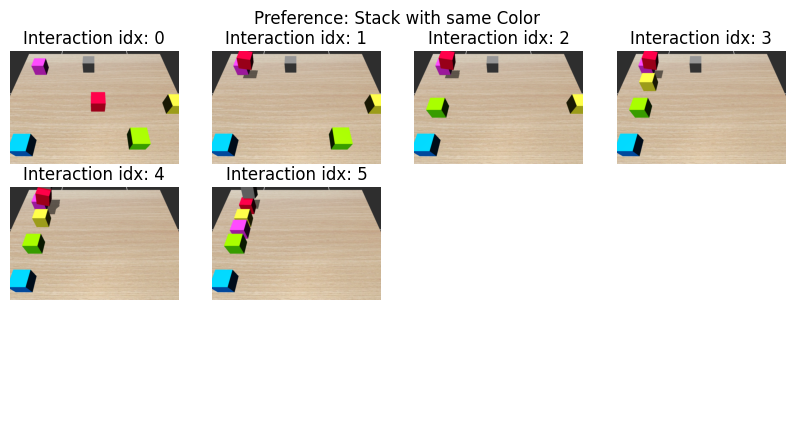

../../dataset/block/vertical/7/rgb_img_0.png
../../dataset/block/vertical/7/rgb_img_1.png
../../dataset/block/vertical/7/rgb_img_2.png
../../dataset/block/vertical/7/rgb_img_3.png
../../dataset/block/vertical/7/rgb_img_4.png
../../dataset/block/vertical/7/rgb_img_5.png
['../../dataset/block/vertical/7/rgb_img_0.png', '../../dataset/block/vertical/7/rgb_img_1.png', '../../dataset/block/vertical/7/rgb_img_2.png', '../../dataset/block/vertical/7/rgb_img_3.png', '../../dataset/block/vertical/7/rgb_img_4.png', '../../dataset/block/vertical/7/rgb_img_5.png']


DETAIL: high

[0/2] image_path: ../../dataset/block/vertical/7/rgb_img_0.png
[1/2] image_path: ../../dataset/block/vertical/7/rgb_img_1.png


[VISUALIZE]

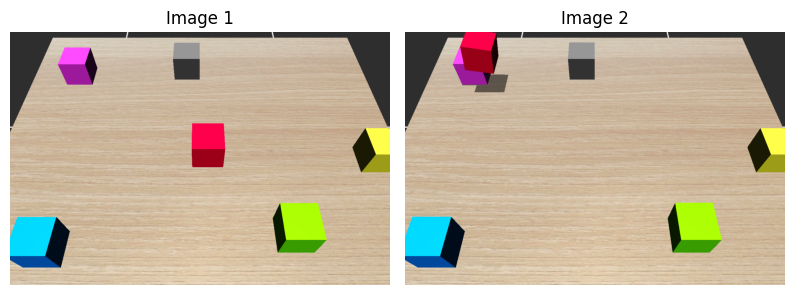

[USER_MSG]


        I will give you <img_1> and <img_2>.
        What actions are performed between the <img_1> and <img_2>?
        only using the following object names: ['obj_box_red', 'obj_box_blue', 'obj_box_green', 'obj_box_yellow', 'obj_box_gray', 'obj_box_magenta'].
        action set: [move_right, move_left, move_in_front_of, move_behind, move_on_top_of]
        # The standard coordinate system is defined as follows: x-axis is up-down (vertical), y-axis is left-right (horizontal)
        


[GPT_OUTPUT]

```json
{
  "action": "move_on_top_of",
  "source_object_name": "obj_box_red",
  "target_object_name": "obj_box_magenta",
  "spatial_relation": "on_top_of",
  "description": "move_on_top_of obj_box_red on_top_of obj_box_magenta"
}
```


DETAIL: high

[0/2] image_path: ../../dataset/block/vertical/7/rgb_img_1.png
[1/2] image_path: ../../dataset/block/vertical/7/rgb_img_2.png


[VISUALIZE]

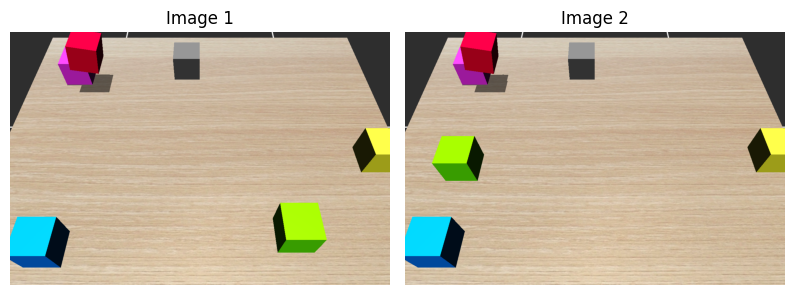

[USER_MSG]


        I will give you <img_2> and <img_3>.
        What actions are performed between the <img_2> and <img_3>?
        only using the following object names: ['obj_box_red', 'obj_box_blue', 'obj_box_green', 'obj_box_yellow', 'obj_box_gray', 'obj_box_magenta'].
        action set: [move_right, move_left, move_in_front_of, move_behind, move_on_top_of]
        # The standard coordinate system is defined as follows: x-axis is up-down (vertical), y-axis is left-right (horizontal)
        


[GPT_OUTPUT]

{
  "action": "move_on_top_of",
  "source_object_name": "obj_box_red",
  "target_object_name": "obj_box_magenta",
  "spatial_relation": "on_top_of",
  "description": "move_on_top_of obj_box_red on_top_of obj_box_magenta"
}


DETAIL: high

[0/2] image_path: ../../dataset/block/vertical/7/rgb_img_2.png
[1/2] image_path: ../../dataset/block/vertical/7/rgb_img_3.png


[VISUALIZE]

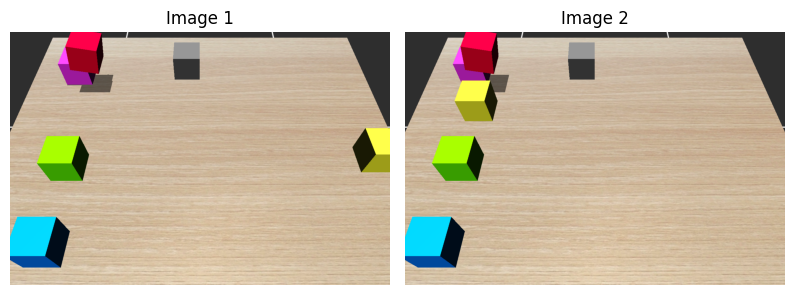

[USER_MSG]


        I will give you <img_3> and <img_4>.
        What actions are performed between the <img_3> and <img_4>?
        only using the following object names: ['obj_box_red', 'obj_box_blue', 'obj_box_green', 'obj_box_yellow', 'obj_box_gray', 'obj_box_magenta'].
        action set: [move_right, move_left, move_in_front_of, move_behind, move_on_top_of]
        # The standard coordinate system is defined as follows: x-axis is up-down (vertical), y-axis is left-right (horizontal)
        


[GPT_OUTPUT]

{
  "action": "move_left",
  "source_object_name": "obj_box_yellow",
  "target_object_name": "obj_box_green",
  "spatial_relation": "in_front_of",
  "description": "move_left obj_box_yellow in_front_of obj_box_green"
}


DETAIL: high

[0/2] image_path: ../../dataset/block/vertical/7/rgb_img_3.png
[1/2] image_path: ../../dataset/block/vertical/7/rgb_img_4.png


[VISUALIZE]

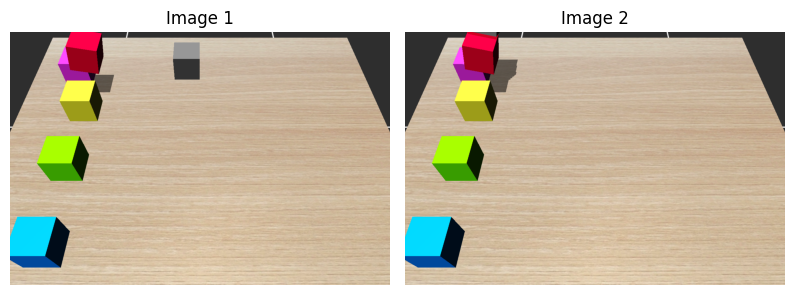

In [6]:
interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0

#%%
dataset_path = '../../dataset/block/'
objective = 'vertical'
path = os.path.join(dataset_path, objective)
folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders, len(folders))

system_prompt = """
You will be given a set of images.
From those, your goal is to reason about the underlying preferences behind the user actions.
You ONLY Respond in JSON format. Do not include any other text in your response.
Format:
{
    "action": <action>,
    "source_object_name": <object_name>,
    "target_object_name": <object_name>,
    "spatial_relation": <spatial_relation>,
    "description": "<action> <source_object_name> <spatial_relation> <target_object_name>"
}

# REMENBER: Only one action is performed in the image.
# Coordinate: x-axis: bottom to top, y-axis: right to left
"""
model.messages = model.init_messages

for folder_idx, folder in enumerate(folders):
    # Backup chat
    model.set_common_prompt(system_prompt)

    interaction_accuracy = None
    preference_accuracy = None

    images = []
    color_folder_path = os.path.join(path, folder)
    # Filter filenames that start with 'rgb_'
    rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('rgb_')]
    # rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('scene_')]
    # Sort it with ends_with number
    sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
    print(sorted_rgb_filenames)
    plt.figure(figsize=(10, 5))
    plt.title("Preference: Stack with same Color",pad=20)
    plt.axis('off')
    for rgb_index, sotred_rgb in enumerate(sorted_rgb_filenames):
        plt.subplot(len(sorted_rgb_filenames)//2, len(sorted_rgb_filenames)//2+1, rgb_index+1)
        plt.title(f"Interaction idx: {rgb_index}")
        plt.imshow(plt.imread(os.path.join(color_folder_path, sotred_rgb)))
        plt.axis('off')
    plt.show()
    for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
        print(os.path.join(color_folder_path, sorted_rgb))
        path_local = os.path.join(color_folder_path, sorted_rgb)
        images.append(path_local)
    print(images)

    response_interaction_list = []
    object_names = ["obj_box_red", "obj_box_blue", "obj_box_green", 
                    "obj_box_yellow", "obj_box_gray", "obj_box_magenta"]

    # model._backup_chat()
    for i in range(0, len(images)-1):
        query_text = f"""
        I will give you <img_{i+1}> and <img_{i+2}>.
        What actions are performed between the <img_{i+1}> and <img_{i+2}>?
        only using the following object names: {object_names}.
        action set: [move_right, move_left, move_in_front_of, move_behind, move_on_top_of]
        # The standard coordinate system is defined as follows: x-axis is up-down (vertical), y-axis is left-right (horizontal)
        """
        response_interaction = model.chat(query_text=query_text, image_paths=images[i:i+2], images=None,
                                    PRINT_USER_MSG=True,
                                    PRINT_GPT_OUTPUT=True,
                                    RESET_CHAT=False,
                                    RETURN_RESPONSE=True,
                                    VISUALIZE=True,
                                    DETAIL='high')
        response_interaction_list.append(response_interaction)
    print(f"\033[94m [Total Token: {model.get_total_token()}] / [Image Token: {model.get_image_token()}] \033[0m")

    query_text = f"""
    Let's try to analyze the images and infer the user's preference.
    Under the assumption that human preferences are consistent over time and that each preference is captured through before and after interaction images.
    And then user’s true preference is represented based on object's attribute (property) or spatial relationships.
    Concentrate only on the changes between the images
    We are assuming that the user's preference is defined as the following, select one of the options in number.
    Based on previous responses, what is the user's preference?
    previouse responses: {response_interaction_list}
    REMEMBER: Please remeber that the preference more related to the overall spatial meaning or patterns, not the exact precision of placing.
    Please summarize your answer in less than three sentences based on the images and history interactions.
    [1: "flocking the objects horizontally", 2: "flocking the objects vertically", 3: "no preference"]
    # REMENBER: Coordinate system is defined as follows: x-axis is up-down (vertical), y-axis is left-right (horizontal
    """
    # , 3: "flcoking in upper side", 4: "flocking in lower side", 5: "flocking in left side", 6: "flocking in right side", 7: "flocking in center", 8
    response_preference = model.chat(query_text=query_text, image_paths=images, images=None,
                                PRINT_USER_MSG=True,
                                PRINT_GPT_OUTPUT=True,
                                RESET_CHAT=True,
                                RETURN_RESPONSE=True,
                                VISUALIZE=True,
                                DETAIL='high')
    response_preference_json, error_message = response_to_json(response_preference)
    preference_list.append(response_preference)
    print(f"objective: {objective}")
    print(f"\033[94m [Total Token: {model.get_total_token()}] / [Image Token: {model.get_image_token()}] \033[0m")
    if folder_idx > 5:
        break